# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
import scipy.stats

In [3]:
from mls import StochasticProcess

## Stochastic Processes

A **stochastic process** is a black-box generator of random sequences
$$
x_0, x_1, x_2, \ldots
$$
where, in general, the value $x_n$ depends on the history of all previous samples, so the black box has long-term memory. The values appearing at the $n$-th position of many runs of the black box sample the random variable $X_n$. In general, samples can be multi-dimensional, $\vec{x}_i$, but this does not present any special challenges or require new concepts so we will stick with the cleaner 1D notation in the following.

Here is a simple example of a general stochastic process (implemented using `mls.StochasticProcess`):

In [4]:
class StochasticExample(StochasticProcess):

    def initial(self, gen):
        return gen.uniform()
    
    def update(self, history, gen):
        return 0.5 * (np.mean(history) + gen.uniform())

Two useful visualizations of a stochastic process are:
 - Plots of a few long runs output by the black box: how does it evolve in "time" $n$?
 - A pair plot of the first few random variables (from many short runs) for a more detailed look at short-range correlations.

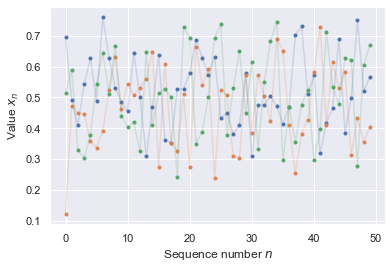

In [5]:
StochasticExample().plot(nsamples_per_run=50, nruns=3)

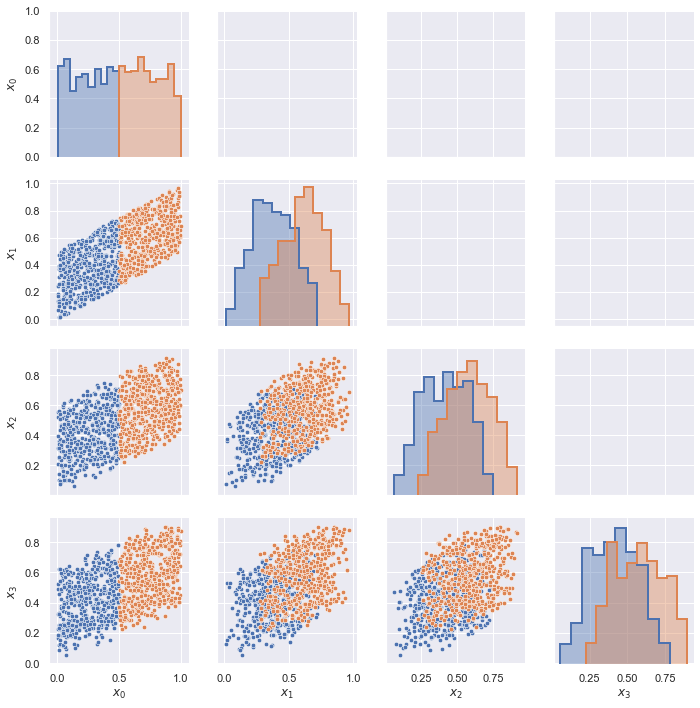

In [6]:
StochasticExample().pairplot(nsamples_per_run=4, nruns=1000, x0cut=0.5)

**EXERCISE:** For each panel of the pairplot above:
 - What distribution of random variables does each panel show?
 - What correlated random variables are marginalized out, if any?
 - What conditional probability do the two colors indicate?
 - Explain how the pairplot answers the question "Are $X_3$ and $X_0$ independent?", i.e. $P(X_3\mid X_0) = P(X_3)$?
 
Hint: the top-left panel shows $P(X_0\mid X_0 \le 0.5)$ and $P(X_0\mid X_0 > 0.5)$, with no marginalization since $X_0$ starts the random sequence.

The histograms show the distributions $P(X_n)$ which are marginalized over $X_{n-1},\ldots, X_0$. The scatter plots show the joint distributions $P(X_i, X_j)$ which are marginalized over $X_{n-1},\ldots, X_0$ with $n = \max(i,j)$ and excluding $X_{\min(i,j)}$. Note that these are distributions of random variables $X_n$, not random values $x_n$.

More explicitly:
 - $P(X_0)$ has no correlated random variables marginalized out since it starts the sequence.
 - $P(X_1)$ is marginalized over $X_0$.
 - $P(X_2)$ is marginalized over $X_1, X_0$.
 - $P(X_3)$ is marginalized over $X_2, X_1, X_0$.
 - $P(X_0, X_1)$ has no correlated random variables marginalized out.
 - $P(X_1, X_2)$ is marginalized over $X_0$.
 - $P(X_2, X_3)$ is marginalized over $X_0, X_1$.
 - $P(X_1, X_3)$ is marginalized over $X_0, X_2$.

The two colors apply the conditions $X_0 \le 0.5$ and $X_0 > 0.5$, so, for example:
 - The $(x_2, x_3)$ scatter plot shows $P(X_2, X_3\mid X_0 \le 0.5)$ and $P(X_2, X_3\mid X_0 > 0.5)$.
 - The $x_3$ histogram shows $P(X_3\mid X_0 \le 0.5)$ and $P(X_3X_0 > 0.5)$.

The difference between the two $x_3$ histograms demonstrates that $P(X_3\mid X_0) \ne P(X_3)$, therefore $X_3$ and $X_0$ are *dependent*. In other words, $X_3$ "remembers" $X_0$.

Note that dependence nearly always implies correlation, but it is possible to construct [artificial counter-examples](https://en.wikipedia.org/wiki/Uncorrelated_random_variables#Example_of_dependence_without_correlation).

---

An observer watching many different sequences generated from the same black box would need to measure all these conditional probabilities to fully describe the process:
$$
P(X_0) \;,\;
P(X_1\mid X_0) \;,\;
P(X_2\mid X_1, X_0) \;,\; \ldots \;,\;
P(X_n\mid P_{n-1}, P_{n-2}\ldots, P_0) \; .
$$
The equivalent Bayesian network (up to $n=3$) is:
![Stochastic process graphical model](img/Markov/stochastic_graph.png)

## Markov Chain

A **Markov chain** is a special type of stochastic process where $X_n$ only depends directly on $X_{n-1}$ and not on any earlier samples. In this case, we say that $X_n$ and $X_{n-2}$ are [conditionally independent](https://en.wikipedia.org/wiki/Conditional_independence).

In other words, a Markov chain is a black box with very short-term memory. The samples $x_0, x_1, \ldots$ produced by a single run of a Markov chain are referred to as a **Markov-chain Monte Carlo (MCMC)**.

Our observer now only needs to measure:
$$
P(X_0) \;,\; P(X_1\mid X_0) \;,\; P(X_2\mid X_1) \;,\; \ldots \;,\; P(X_n\mid X_{n-1}) \; .
$$
The equivalent Bayesian network is:
![Markov chain graphical model](img/Markov/markov_graph.png)
Random variables without a direct connection (arrow) are conditionally independent.

An important subset of Markov chains are **stationary**, which makes our observer's job even easier since they have the property that
$$
P(X_1\mid X_0) = P(X_2\mid X_1) = \ldots = P(X_n\mid X_{n-1}) \; .
$$
In other words, a black box with very short-term memory and no sense of time.  Our observer now only has two conditional probability distributions to measure, the initial probability,
$$
P(X_0) \; ,
$$
and the update rule for $n\ge 1$,
$$
P(X_n\mid X_{n-1}) \; .
$$

Here is a simple example of a stationary Markov process:

In [7]:
class StationaryMarkovExample(StochasticProcess):

    def initial(self, gen):
        return gen.uniform()
    
    def update(self, history, gen):
        return 0.5 * (history[-1] + gen.uniform())

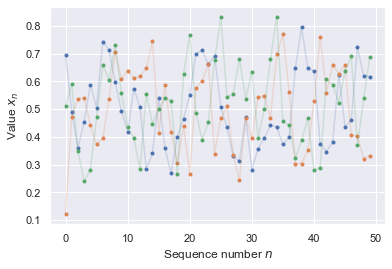

In [8]:
StationaryMarkovExample().plot(nsamples_per_run=50, nruns=3)

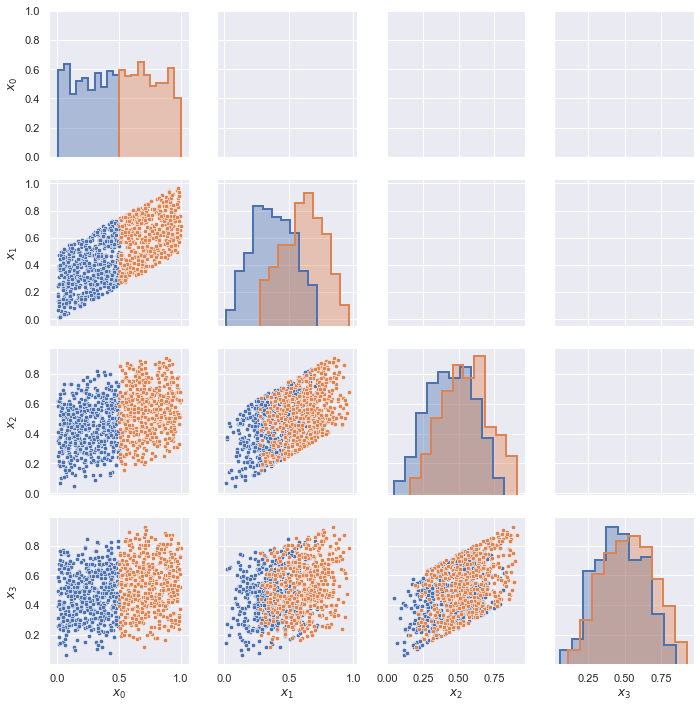

In [9]:
StationaryMarkovExample().pairplot(nsamples_per_run=4, nruns=1000, x0cut=0.5)

The pairplot above demonstrates that $X_n$ and $X_0$ are still dependent, $P(X_n\mid X_0) \ne P(X_n)$, even for a Markov process! Some probability calculus shows how this happens. Take $n=2$ for simplicity:
$$
\begin{aligned}
P(X_2\mid X_0) &= \int dX_1\, P(X_2, X_1\mid X_0) \\
&= \int dX_1\, P(X_2\mid X_1, X_0)\, P(X_1\mid X_0) \\
&= \int dX_1\, P(X_2\mid X_1)\, P(X_1\mid X_0) \; ,
\end{aligned}
$$
where the first two lines are completely general, but the last assumes a Markov process, $P(X_2\mid X_1, X_0) = P(X_2\mid X_1)$.  Compare with:
$$
\begin{aligned}
P(X_2) &= \int dX_1 dX_0\, P(X_2, X_1, X_0) \\
&= \int dX_1 dX_0\, P(X_2\mid X_1, X_0)\, P(X_1, X_0) \\
&= \int dX_1\, P(X_2\mid X_1)\, \int dX_0\, P(X_1, X_0) \\
&= \int dX_1\, P(X_2\mid X_1)\, P(X_1) \; .
\end{aligned}
$$
The comparison shows that $P(X_2\mid X_0) = P(X_2)$ would require that $P(X_1\mid X_0) = P(X_1)$.  In other words, the direct dependence of each $X_n$ on $X_{n-1}$ is sufficient to generate long-range dependencies all the way back to $X_0$.

Another important property that some Markov chains have is **reversibility**,
$$
P(X_n\mid X_{n-1}) = P(X_{n-1}\mid X_n)
$$
which can also be defined in terms of forward conditional probabilities as
$$
P(X_n=x\mid X_{n-1}=y) = P(X_{n+1}=y\mid X_n=x) \; ,
$$
and roughly corresponds to time-reversal invariance.

*A reversible chain is always stationary, but not vice versa.*

The update rule for a stationary Markov chain,
$$
P(X_n\mid X_{n-1}) \; .
$$
can be conveniently visualized with a 2D plot. For example, taking $n=1$:

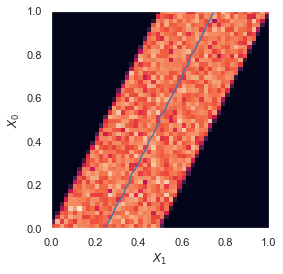

In [10]:
StationaryMarkovExample().plot_conditionals(which=1)

The blue line shows the mean $X_1$ at each $X_0$,
$$
\langle X_1\rangle = \int dX_1\, X_1\, P(X_1\mid X_0) \; .
$$
Note that this is essentially the $(x_1, x_0)$ scatter plot from above, but with samples now histogrammed to yield conditional probabilities.

**DISCUSS:**
 - The speckling is due to using finite statistics to estimate the probability. How would this plot look different with infinite statistics?
 - This plot shows $P(X_1\mid X_0)$. Would $P(X_2\mid X_1)$ look any different? How about $P(X_2\mid X_0)$?
 - Are these conditional probabilities normalized along $X_0$? along $X_1$?
 - How would this plot change if we changed the definition of `initial()` in `StationaryMarkovExample`?
 - What condition on this plot does a reversible Markov chain satisfy? Is this example reversible?

With infinite statistics, the diagonal band would be a uniform color, since $P(X_1\mid X_0)$ is uniform (within the diagonal limits shown) for each $X_0$.

A plot of $P(X_2\mid X_1)$, or any $P(X_{n+1}\mid X_n)$ would like identical since this is the definition of a stationary Markov chain. However, $P(X_2\mid X_0)$ involves two updates, so its plot might look different.

A conditional probability $P(\alpha\mid \beta)$ is normalized along $\alpha$, with the value of $\beta$ considered fixed. In other words, a numpy array of values `T[n,m]` tabulating $P(X_m\mid X_n)$ on a grid satisfies:
```
np.sum(T, axis=1) = 1
```

This plot only shows the update rule and does not depend on how we chose an initial value for the Markov chain.

A reversible Markov chain has $P(X_1\mid X_0) = P(X_0\mid X_1)$, which makes this plot symmetric under the interchange of its axes. In other words, mirroring the plot along the diagonal should not change its appearance. Since this is not true in this example, `StationaryMarkovExample` is not reversible.

---

## Equilibrium Distributions

Repeated use of the (same) update rule associated with a stationary Markov chain reveals a useful feature. These plots show 1, 2, 4, and 8 iterations of the same rule:

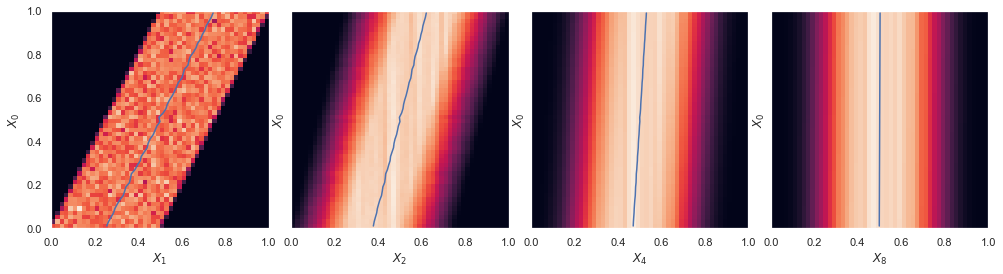

In [11]:
StationaryMarkovExample().plot_conditionals(which=(1, 2, 4, 8))

**A stationary Markov chain eventually reaches an equilibrium $P(X_n\mid X_0) \rightarrow \tilde{P}(X_n)$ that does not depend on $X_0$.**

We saw earlier how, in general, $X_n$ and $X_0$ are dependent, but we now learn that stationarity tames this behavior and guarantees that $X_n$ and $X_0$ are independent for sufficiently large $n$.

We will not prove this result, but here is a less trivial example to help build the case:

In [12]:
class StationaryMarkovExample2(StochasticProcess):

    def initial(self, gen):
        return gen.uniform()
    
    def update(self, history, gen):
        return np.abs(np.fmod(np.cos(2 * np.pi * history[-1]) + 0.1 * gen.normal(), 1))

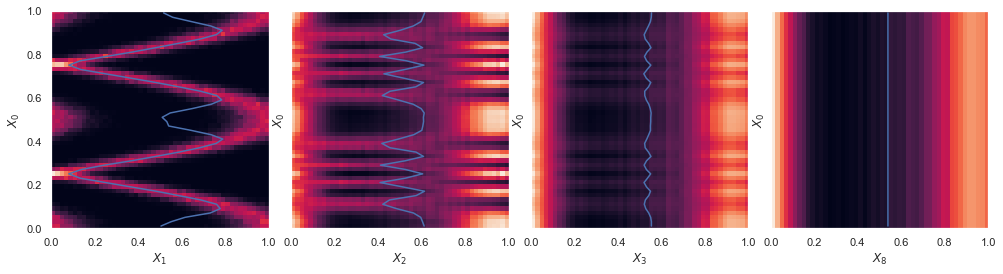

In [13]:
StationaryMarkovExample2().plot_conditionals(which=(1, 2, 3, 8))

For practical applications, there are two issues to deal with:
 - There is no way to know in advance how big $n$ needs to be to achieve equilibrium.
 - Given some stationary Markov chain, we can generate samples from *some* equilibrium distribution $\tilde{P}(X_n)$, but how do we build a chain to sample a specific distribution?

The second issue requires solving an [inverse problem](https://en.wikipedia.org/wiki/Inverse_problem), which is generally challenging. However, there is a general class of solutions that we will look at below.

**EXERCISE:** Define your own Markov chain, following the `StationaryMarkovExample` above, and make similar plots. Is your chain stationary? For a challenge, try to build a reversible chain.

The test for a stationary chain is whether it only uses `history[-1]` in its `update()` method.  The test for a reversible chain is whether its plot of $P(X_1\mid X_0)$ is symmetric about the diagonal.

Here is an example of a reversible (and therefore stationary) Markov chain:

In [14]:
class ReversibleMarkovExample(StochasticProcess):

    def initial(self, gen):
        return gen.uniform()
    
    def update(self, history, gen):
        return np.fmod(history[-1] + 0.2 * gen.normal() + 1, 1)

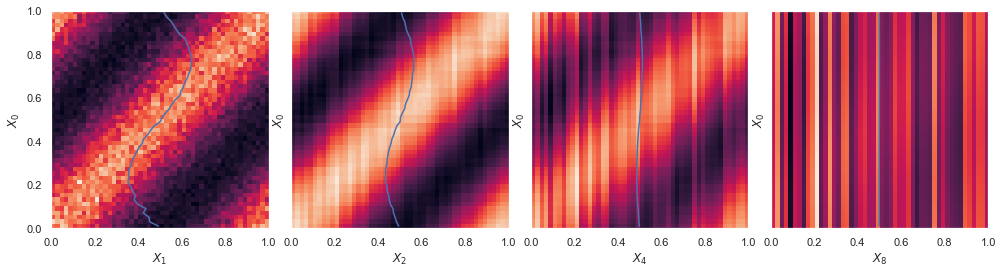

In [15]:
ReversibleMarkovExample().plot_conditionals(which=(1, 2, 4, 8))

Note that we can use the diagonal symmetry of the first plot to confirm that this is a reversible chain.

---

In [35]:
class StationaryMarkovExample3(StochasticProcess):

    def initial(self, gen):
        return gen.uniform()
    
    def update(self, history, gen):
        return (2*np.abs(history[-1] - 0.5) + 0.2*gen.uniform())

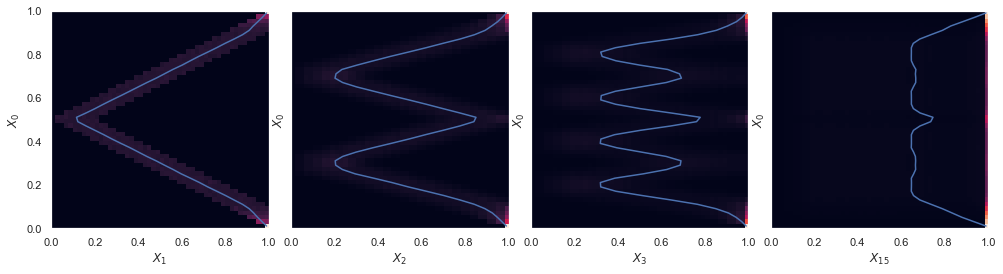

In [37]:
StationaryMarkovExample3().plot_conditionals(which=(1, 2, 3, 15))

## Custom Markov Chains

The Metropolis-Hastings-Green (MHG) algorithm is a general approach to designing a custom Markov chain that has a specified target probability density, $\tilde{P}(X_n)$.  All practical algorithms are special cases of MHG:
 - Metropolis-Hastings-Green
   - Metropolis-Hastings
     - Metropolis
     - Gibbs
     - Hamiltonian
     
The simpler Metropolis-Hastings (MH) algorithm contains the essential ideas so we will focus on that.

The history of using Markov chains for practical inference is intimately connected with physics: many of the pioneers were physicists motivated by physics problems, including [Metropolis](https://en.wikipedia.org/wiki/Nicholas_Metropolis) and [Gibbs](https://en.wikipedia.org/wiki/Josiah_Willard_Gibbs), and the Hamiltonian method derives from classical mechanics.

See this [blog post](http://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/) for helpful animations comparing some of these methods.

### Metropolis-Hastings Updates

The MH algorithm relies on a **proposal distribution** $Q(X_{n+1}\mid X_n)$ that is easier to sample than $\tilde{P}(X_{n+1}\mid X_n)$.  (If you knew how to sample $P$ directly, you would not need MCMC!)

We often use a multivariate Gaussian for $Q$ since it is easy (and efficient) to sample from. Any proposal distribution is valid, but choosing a $Q$ "closer" to $P$ generally reaches the desired equilibrium faster.

The proposal distribution can either be used to update to the current state ("random walk") or to generate a new state:

In [46]:
def sample_proposal(x0, gen, mu, C, mode):
    sample = gen.multivariate_normal(mu, C)
    return x0 + sample if mode == 'random_walk' else sample

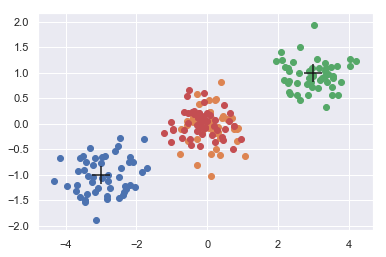

In [47]:
def plot_proposals(n=50, seed=123):
    gen = np.random.RandomState(seed=seed)
    mu = np.zeros(2)
    C = np.diag((.3, .1))
    
    for xy0 in np.array([-3, -1]), np.array([3, 1]):
        xy = np.array([sample_proposal(xy0, gen, mu, C, 'random_walk') for i in range(n)])
        plt.scatter(*xy.T, label='random_walk')
        #Independent ignores xy0
        xy = np.array([sample_proposal(xy0, gen, mu, C, 'independent') for i in range(n)])
        plt.scatter(*xy.T, label='independent')
        plt.scatter(*xy0, marker='+', s=300, c='k')
    
plot_proposals()

During each update we evaluate a proposed move to $x_{n+1}$ by calculating the **Hastings ratio**,
$$
r(x_{n+1}, x_n) = \frac{\tilde{P}(x_{n+1})}{\tilde{P}(x_n)}\, \frac{Q(x_n\mid x_{n+1})}{Q(x_{n+1}\mid x_n)} \; ,
$$
where $\tilde{P}$ is the desired equilibrium distribution. Since $\tilde{P}$ only appears in a ratio, it does not need to be normalized: we saw earlier how this freedom is very useful for performing Bayesian inference, where the normalization is generally not calculable.

In general, the Hastings ratio is $\ge 0$ but it can otherwise be arbitrarily large. We always accept a proposed move when $r(x_{n+1}, x_n) \ge 1$.  Otherwise, we accept it with a probability of $0\le r(x_{n+1}, x_n) < 1$.  When a proposed move is rejected, the update returns the original value (so repetitions are possible and quite normal).

In practice, we work with
$$
\log r(x_{n+1}, x_n) = \log \tilde{P}(x_{n+1}) - \log \tilde{P}(x_n)
+ \log Q(x_n\mid x_{n+1}) - \log Q(x_{n+1}\mid x_n)
$$
rather than $r(x_{n+1}, x_n)$ in order to minimize the effects of round-off errors.

We can now build a simple custom Markov chain for an arbitrary target equilibrium distribution:

In [50]:
class MetropolisHastings(StochasticProcess):

    def __init__(self, x0, Qrms, logP, mode, seed=123):
        super().__init__(seed)
        self.x0 = np.asarray(x0)
        self.Q = scipy.stats.multivariate_normal(
            mean=np.zeros_like(x0), cov=np.diag(Qrms ** 2 * np.ones_like(x0)))
        self.logP = logP
        self.mode = mode
    
    def initial(self, gen):
        # Start from the origin.
        return self.x0
    
    def update(self, history, gen):
        x0 = history[-1]
        
        # Sample the proposal distribution Q to generate x1 and calculate
        # the log of the proposal ratio.
        sample = self.Q.rvs(random_state=gen)
        if self.mode == 'random_walk':
            x1 = x0 + sample
            log_Q_ratio = 0. # self.Q.logpdf(x0-x1) - self.Q.logpdf(x1-x0)
        else:
            x1 = sample
            log_Q_ratio = self.Q.logpdf(x0) - self.Q.logpdf(x1)
        
        # Calculate log of the Hastings ratio.
        log_ratio = self.logP(x1) - self.logP(x0) + log_Q_ratio
        
        # Accept x1 or keep x0?
        if log_ratio >= 0:
            return x1
        else:
            accept_prob = np.exp(log_ratio)
            return x1 if gen.uniform() < accept_prob else x0

Define the un-normalized PDF for samples that are uniformly distributed within a (hyper)cube spanning $[-1,+1]$ along each axis:

In [51]:
def logP(x):
    return 1. if np.max(np.abs(x)) < 1 else -np.inf

Generate samples in 2D using a 2D Gaussian with zero mean and unit variance for the proposal distribution $Q$. Use the following utiliity function to make a scatter plot of the results using:
 - color to indicate the last position $n$ in the chain,
 - a superimposed plus ($+$) to indicate samples repeated twice,
 - a superimposed asterisk ($\ast$) to indicate samples repeated three or more times,
 - a larger circle to indicate the initial position, and
 - a dashed box showing the boundary of the target (square) distribution.

In [54]:
def plot_square(xy):
    _, ax = plt.subplots(figsize=(8, 8))
    xy_unique, xy_counts = np.unique(xy, axis=0, return_counts=True)
    repeated = xy_counts > np.arange(3).reshape(-1, 1)
    ax.scatter(*xy.T, s=100, c=np.arange(len(xy)), cmap='gist_rainbow', lw=0)
    ax.scatter(*xy[0], s=400, marker='o', edgecolors='k', facecolors='none', lw=2)
    ax.scatter(*xy_unique[repeated[1]].T, marker='+', s=30, c='w', lw=1, zorder=10)
    ax.scatter(*xy_unique[repeated[2]].T, marker='x', s=30, c='w', lw=1, zorder=10)
    ax.set_title('Chain has {} / {} unique samples with {} repeated'
                 .format(len(xy_unique), len(xy), np.count_nonzero(repeated[1])), fontsize='x-large')
    ax.set_xlim(-1.1, 1.1); ax.set_ylim(-1.1, 1.1)
    ax.add_artist(plt.Rectangle([-1,-1], 2, 2, fc='none', ec='k', ls='--', lw=1))

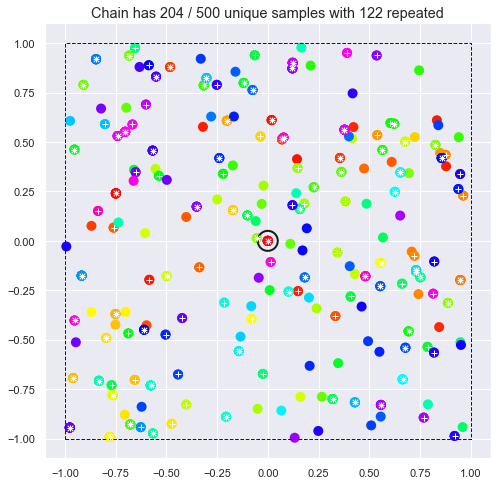

In [53]:
plot_square(MetropolisHastings([0,0], 1., logP, 'random_walk').run(500))

Note that the unique points in the sample do cover the square uniformly and there is no obvious imprint of the Gaussian proposal distribution. However, there are also many repetitions and, more generally, successive points are highly correlated with each other.

The example above worked out reasonably well, but there are many pitfalls with the MH algorithm, some obvious and others more subtle:

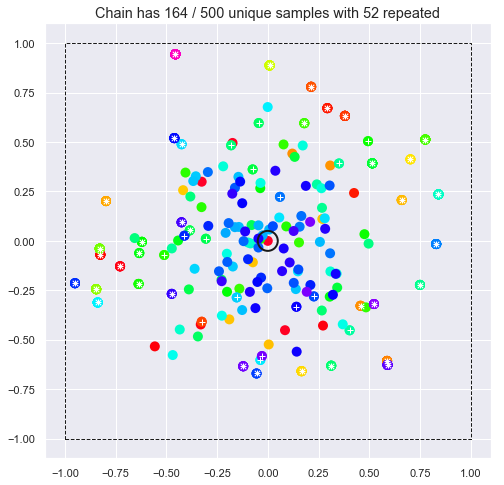

In [23]:
plot_square(MetropolisHastings([0,0], 0.3, logP, 'independent').run(500))

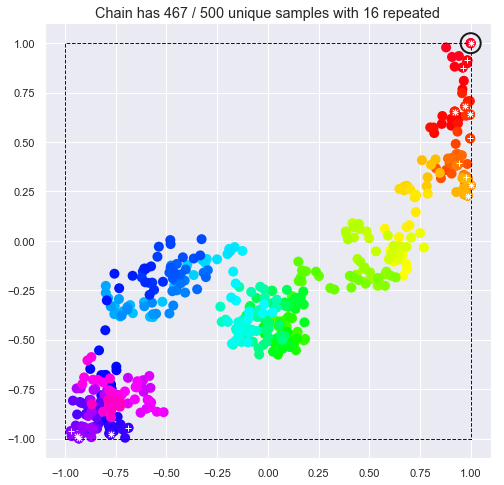

In [24]:
plot_square(MetropolisHastings([1, 1], 0.05, logP, 'random_walk').run(500))

**EXERCISE:** Study the two examples above and describe how and why they are failing to sample the desired target distribution. Do the locations of repeated samples make sense?

The first example uses independent updates with a proposal distribution that is too narrow ($\sigma = 0.3$) to sample the edges of the box efficiently.  As a result, points far from the initial point (the origin) are repeated often and the chain would need to be much longer to populate the corners. Note that, although the density of samples is higher close to the origin, when weighted by the number of repetitions, the generated chain correctly samples the target (flat) distribution.

The second example use random-walk updates with a proposal distribution that is much narrower than the target ($\sigma = 0.05$) so tends to explore the target space slowly with long range correlations between samples. We have effectively simulated the [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion) of a particle in a 2D fluid. With a long enough chain, our particle will explore the full square, spending about the same amount of time in each part of it, but this is not true of shorter sections of the chain. Note how repeated samples occur only at the edges of square, where there is a high probability of a proposed sample falling outside the square and therefore being rejected.

Both of these examples are "correct" implementations of MH updates, but also have peculiar features that you might care about when using MCMC for pratical work. The lesson is that you should generally not assume that an MCMC chain has any desirable properties beyond its minimum guarantee of asymptotically sampling $\tilde{P}(X_n)$.

---

When the proposal distribution $Q$ is reversible, it cancels in the Hastings ratio,
$$
r(x_{n+1}, x_n) = \frac{\tilde{P}(x_{n+1})}{\tilde{P}(x_n)}\, \frac{Q(x_n\mid x_{n+1})}{Q(x_{n+1}\mid x_n)} \;\rightarrow\; \frac{\tilde{P}(x_{n+1})}{\tilde{P}(x_n)} \; .
$$
The resulting **Metropolis updates** are a special case of MH updates and eliminate the need to evaluate $Q$.

### Gibbs Sampling

When sampling a multidimensional target distribution $\tilde{P}$, some additional constraints on $\tilde{P}$, allow us to exploit a different special case of MH updates and are the basis of **Gibbs sampling**.

For example, suppose we want to sample in 3D from $\tilde{P}(x, y, z)$, then Gibbs updates require that we can sample from each of the 1D conditional distributions:
$$
\tilde{P}(x\mid y, z) \quad ,\quad
\tilde{P}(y\mid x, z) \quad ,\quad
\tilde{P}(z\mid x, y) \; .
$$
This condition is trivially satisfied when the random variables are mutually independent,
$$
\tilde{P}(x,y,z) = P_X(x) P_Y(y) P_Z(z) \; ,
$$
but is more useful in cases where this is not true and simpler alternative methods are not available.

The rules for a single Gibbs update starting from sample $(x_{n-1}, y_{n-1}, z_{n-1})$ are:
 - Sample $x_n$ from $\tilde{P}(x\mid y_{n-1}, z_{n-1})$
 - Sample $y_n$ from $\tilde{P}(y\mid x_n, z_{n-1})$
 - Sample $z_n$ from $\tilde{P}(z\mid x_n, y_n)$
 - Accept the new sample $(x_n, y_n, z_n)$ with probability one (!)
 
We will not prove the correctness of this approach, but the key insight is that each sub-step samples from a conditional PDF that is proportional to the full joint PDF, for example:
$$
\tilde{P}(y\mid x, z) = \frac{\tilde{P}(x, y, z)}{\tilde{P}(x, z)} \propto \tilde{P}(x, y, z) \; .
$$
The 3D example above generalizes in the obvious way to higher dimensions.

[Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) places extra conditions on $\tilde{P}$, so is not a general-purpose algorithm, but is efficient and eliminates repeated samples when its conditions are met.  Gibbs sampling is often a good fit to target distributions that can be expressed using a graphical model with few dependencies.

### Hamiltonian Sampling

Another special case of MH sampling requires that we can calculate all partial derivatives of our target $\log\tilde{P}$,
$$
\frac{\partial}{\partial z_i}\, \log\tilde{P}(\vec{x}) \; .
$$
The resulting **Hamiltonian sampling** method relies on a nifty physics analogy.

[Recall](https://en.wikipedia.org/wiki/Hamiltonian_mechanics) that the equations of motion for a classical system of particles with Hamiltonian $H$ are:
$$
\frac{dq_i}{dt} = + \frac{\partial H}{\partial p_i} \quad , \quad
\frac{dp_i}{dt} = - \frac{\partial H}{\partial q_i} \; ,
$$
where $q_i$ and $p_i$ are (generalized) position and momentum coordinates for particle $i$.

We identify $H$ with the total energy of the system and can often split it into separate kinetic and potential terms,
$$
H(q,p) = K(p) + U(q) \; ,
$$
where, generically,
$$
K(p) = \sum_i\, \frac{p_i^2}{2 m_i} \; ,
$$
with particle "masses" $m_i$, and $U(q)$ encapsulates all the specifics of a particular system. Using this split, we can simplify the equations of motion to:
$$
\frac{dq_i}{dt} = +\frac{p_i}{m_i} \quad ,\quad \frac{dp_i}{dt} = -\frac{\partial U}{\partial q_i} \; .
$$

We turn Hamiltonian dynamics into a stationary Markov chain with the following recipe:
 - Identify positions $q_i$ with the random variables we wish to sample.
 - Create new random variables $p_i$ for the corresponding momenta. We will treat these are nuisance parameters, but this does not look promising since we just doubled the dimension of our sampling space!
 - Assign fixed (arbitrary) masses $m_i$ to each "particle".
 - Use $U(q) = -\log\tilde{P}(q)$ for our "potential energy".
 
Plugging $U(q) = -\log\tilde{P}(q)$ into the $dp_i/dt$ equation of motion above reveals why we need to be able to calculate partial derivatives of $\log\tilde{P}$.

A single Hamiltonian Monte Carlo (HMC) update then consists of:
 - Pick a random starting point in $(q, p)$ space, to specify the initial conditions for our "particles".
 - Follow the evolution of our "particles" for some fixed time interval using Hamiltonian dynamics.
 - Use the final positions of our "particles" as a new sample added to the chain.

How does this sample the target $\tilde{P}(q)$? The answer comes from statistical mechanics, which tells us that the probability that our system of particles is in a state with positions $q$ is given by the [canonical distribution](https://en.wikipedia.org/wiki/Canonical_ensemble):
$$
P(q) \propto \exp\left( -\frac{U(q)}{k_B T} \right) \; ,
$$
where $k_B$ is Boltzmann's constant and $T$ is the system's absolute temperature.

In practice, you can usually set $k_B T = 1$ and all masses $m_i = 1$ and this works surprisingly well!  The disadvantages of this approach are that:
 - It is relatively complex to implement, compared with the much simpler (and general purpose) MH sampling, so let someone else do this work for you.
 - It requires that you can evaluate all the necessary partial derivatives of your target $\tilde{P}$.

However, the main advantage is that HMC can often explore the target space much more efficiently than other methods, since it uses the additional information provided by the derivatives.  We will soon discuss computational graphs, which are a general-purpose framework for automating the necessary derivate calculations.

See this [blog post](http://arogozhnikov.github.io/2016/12/19/markov_chain_monte_carlo.html) for a more detailed explanation of HMC with some helpful interactive visualizations.

## Practical Advice

It is tempting to assume that MCMC samples have desirable properties beyond their minimum guarantees, since this is often true, but avoid this temptation.

In particular, MCMC samples are only guaranteed to sample your target $\tilde{P}(X_n)$ for $n$ sufficiently large. Therefore:
 - There is no way to know how big $n$ needs to be for a particular $\tilde{P}$.
   - **Burn-in?** Should I throw away the first $B$ samples to ensure that my chain is independent of its initial starting point?
   - **No:** There is no practical way to know how big $B$ should be. Instead, ensure that your starting point is reasonably probable (according to $\tilde{P}$) and use all samples. If you do not know how to chose a reasonably probably starting point, you need to solve a separate optimization problem before you are ready to use MCMC (which is notoriously inefficient at discovering new regions of high probability).
 - There are no useful guarantees about $\tilde{P}(X_n, X_m)$ and, in general, you should assume that the consecutive samples in any stretch of the chain are highly correlated.
   - **Thinning?** Should I just keep every $T$-th sample so that my chain is uncorrelated?
   - **No:** There is no practical way to know in advance how big $T$ should be, and you can never get a better answer (for a fixed amount of computation) by throwing away valid information. Just accept that samples are correlated.

How long should your chain be?  You should ideally use empirical measurements to determine $k$ such that the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)
$$
\frac{\langle (X_{n+k} - \mu) (X_n - \mu)\rangle}{\sigma^2} \simeq 0 \; ,
$$
where $\mu$ and $\sigma$ are the long-term mean and standard deviation of $\tilde{P}(X_n)$, then generate a chain whose length is at least 10-100 times this [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) length $k$.

Which update rule should you use?
 - Determine which special cases apply to your target $\tilde{P}$, so you know which algorithms are possible.
   - Can you sample from a complete set of conditional distributions?  If so, add Gibbs sampling to your list.
   - Can you compute all partial derivatives? If so, add HMC to your list.
 - There is no "best" algorithm, so you will need to benchmark your problem against the available methods. 

Although it is instructive (and fun!) to implement simple update rules yourself, for serious work you should generally let someone else do the hard work for you by using an existing package.

Which package should you use?
 - For initial exploratory work, start with [emcee](http://dfm.io/emcee/), which implements [ensemble sampling](http://dx.doi.org/10.2140/camcos.2010.5.65) where many independent "walkers" simultaneously crawl around your target space, and has a nice [affine invariance](https://en.wikipedia.org/wiki/Affine_geometry) property, where the efficiency is not affected by any linear (aka "affine") transformation of your target space.
 - Look into [PyMC3](http://docs.pymc.io/notebooks/getting_started.html), [Edward](http://edwardlib.org/) (based on tensorflow) or [Pyro](http://docs.pyro.ai/en/0.2.1-release/index.html) (based on PyTorch) to explore HMC and other more advanced updating rules. These are generally more complex to use and have rigid rules for specifying your target $\tilde{P}$.
 - Consider an alternative approximate method for Bayesian inference, such as [variational inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods), with different tradeoffs.
 
This [blog post](http://twiecki.github.io/blog/2013/09/23/emcee-pymc/) compares emcee and PyMC3.